In [1]:
# Useful starting lines
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

import pandas as pd

from tqdm.auto import tqdm

np.random.seed(239) 

In [2]:
from implementations import *
from helpers import *

y, X, ids = load_csv_data("data/train.csv")
y[y == -1] = 0

In [3]:
X = np.concatenate((X, np.ones((len(X), 1))), axis=1)
X.shape, y.shape

((250000, 31), (250000,))

In [4]:
X_test = np.genfromtxt('data/test.csv', delimiter=",", skip_header=1)
X_test = X_test[:, 2:]
X_test = np.concatenate((X_test, np.ones((len(X_test), 1))), axis=1)
X_test.shape

(568238, 31)

In [5]:
def imputer(data):
    data[data == -999] = np.nan
    col_mean = np.nanmedian(data, axis=0)
    inds = np.where(np.isnan(data))
    data[inds] = np.take(col_mean, inds[1])
    return data

Replacing missing values(-999) with the median and standardization of the train and test data

In [6]:
X = imputer(X)
X_test = imputer(X_test)

In [7]:
X, _, _ = standardize(X)
X_test, _, _ = standardize(X_test)

### knn

The function works as follows:

First, we count the array `dists`, which are the pairwise distances between the train and test points. 


Then for each point from the test we take the nearest `k` neighbors and sort the resulting array. After that, using prefix sums, we count the answer for each value of the number of neighbors from 1 to `k` (as an average value).


Thus, each prediction will be equal to a number from 0 to 1 (the average value of classes of its neighbors). And then we convert this number to a class simply by trasholding `0.5`.

In [8]:
# Implementation of the K-nearest neighbors algorithm
# It takes as input test and train data 
# and the number k - the maximum number of neighbors for which we need to calculate the predictions.

# The function returns a matrix ys of shape (len(X_test, k)
# Where ys[i][j] is the answer for the i-th element of the test dataset and k = j
def knn(X_train, y_train, X_test, k):
    X_train_sqr = np.sum(X_train ** 2, axis=1)
    X_test_sqr = np.sum(X_test ** 2, axis=1)
    
    # Array of pairwise distances
    dists = X_test_sqr[:, None] - 2 * X_test @ X_train.T + X_train_sqr[None, :]

    # We choose only the minimum k neighbors
    min_dists = np.argpartition(dists, k - 1, axis=1)[:, :k]
    
    # We leave only these minimum neighbors and sort the remaining array of distances
    dists = dists[np.arange(len(dists))[:, None], min_dists]
    min_dists2 = np.argsort(dists, axis=1)
    
    # Using prefix sums, we calculate the answer for each number of neighbors from 1 to k (as an average over them)
    ys = np.cumsum(y_train[min_dists[np.arange(len(min_dists2))[:, None], min_dists2]], axis = 1) / (np.arange(k) + 1)
    ys = (ys >= 0.5).astype(np.float64)
    
    return ys

Function of cross validation, which splits a train into train (80\% of initial quantity) and test (20\% of initial quantity) works quickly (about 3 minutes) and outputs accuracy value for test validation data for any k.

In [9]:
from tqdm.auto import tqdm, trange

# Cross validation function for knn
# Divides the train set by 80% for training and 20% for validation.
# And it calculates accuracy for each number of neighbors from 1 to k
# Returns the values of all accuracy
def cross_validation(X, y, k):  
    X_train, X_test, y_train, y_test = split_data(X, y, 0.8)

    # Batch size to pass only part of X_test to knn function (to avoid memory overflow)
    BATCH_SZ = 512
    y_pred_array = []
    for i in trange(0, len(X_test), BATCH_SZ):
        y_pred_array.append(knn(X_train, y_train, X_test[i:i + BATCH_SZ], k))
        
    y_pred = np.concatenate(y_pred_array)
    
    accuracy = []
    for i in range(k):
        accuracy.append(np.sum(y_pred[:, i] == y_test) / len(y_test))
        
    # We can also use MSE-loss instead of accracy
    # loo_mses = []
    # for i in range(k):
    #    loo_mses.append(np.mean((y_pred[:, i] - y_test)**2))
        
    return accuracy

In [10]:
# Calculating the best k and build an accuracy plot
k = 1000
ks = np.arange(k) + 1
values = cross_validation(X, y, k=k)

  0%|          | 0/98 [00:00<?, ?it/s]

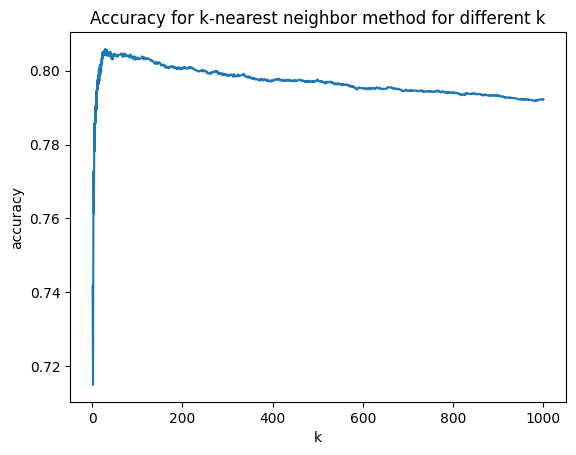

Max accuracy = 0.80592 Best k = 29


In [11]:
plt.plot(ks, values)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Accuracy for k-nearest neighbor method for different k')

plt.show()

print('Max accuracy =', np.max(values), 'Best k =', ks[np.argmax(values)])
k_opt = ks[np.argmax(values)]

In [12]:
# Calculating the predictions for the test data
BATCH_SZ = 1024
predictions = []

for i in trange(0, len(X_test), BATCH_SZ):
    predictions.append(knn(X, y, X_test[i:i + BATCH_SZ], k=k_opt)[:, k_opt - 1])

predictions_knn = np.concatenate(predictions)
predictions_knn[predictions_knn == 0] = -1

# Accuracy = 0.808
data_test = pd.read_csv('data/test.csv')
create_csv_submission(np.array(data_test.Id), predictions_knn, 'knn')

  0%|          | 0/555 [00:00<?, ?it/s]